# Proyek Analisis Data: [Air-quality-dataset]
- **Nama:** [Achmad Yusuf Yulestiono]
- **Email:** [yahmad15322@gmail.com]
- **ID Dicoding:** [achmadyusuy]

# Pertanyaan Bisnis
 1. Bagaimana tren kualitas udara di berbagai stasiun dari tahun 2013-2017?
 2. Apakah ada korelasi antara suhu (TEMP) dan tingkat PM2.5?
 3. Bagaimana perbandingan tingkat polusi (PM2.5, PM10, SO2, NO2) antar stasiun?
 4. Teknik lanjutan: RFM Analysis, Clustering, Geospatial Analysis

# Import libraries

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pathlib import Path
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Data Wrangling

Gathering Data

In [3]:
data_folder = Path('data')
data_files = list(data_folder.glob('*.csv'))  

dfs = []
for file in data_files:
    df = pd.read_csv(file)
    dfs.append(df)

Combine all dataframes

In [4]:
# Menggabungkan semua dataframe
air_quality_data = pd.concat((pd.read_csv(f) for f in data_folder.glob('*.csv')), ignore_index=True)


Assessing Data

In [5]:
print(air_quality_data.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB
None


In [40]:
print(air_quality_data.describe())

                  No           year          month            day  \
count  420768.000000  420768.000000  420768.000000  420768.000000   
mean    17532.500000    2014.662560       6.522930      15.729637   
std     10122.116943       1.177198       3.448707       8.800102   
min         1.000000    2013.000000       1.000000       1.000000   
25%      8766.750000    2014.000000       4.000000       8.000000   
50%     17532.500000    2015.000000       7.000000      16.000000   
75%     26298.250000    2016.000000      10.000000      23.000000   
max     35064.000000    2017.000000      12.000000      31.000000   

                hour          PM2.5           PM10            SO2  \
count  420768.000000  412029.000000  414319.000000  411747.000000   
mean       11.500000      79.793428     104.602618      15.830835   
std         6.922195      80.822391      91.772426      21.650603   
min         0.000000       2.000000       2.000000       0.285600   
25%         5.750000      20.0000

## Cleaning Data

Menangani missing values

In [6]:

air_quality_data = air_quality_data.dropna()

Konversi kolom tanggal

In [7]:

air_quality_data['date'] = pd.to_datetime(air_quality_data[['year', 'month', 'day']])


Save cleaned data for dashboard


In [19]:
air_quality_data.to_csv('dashboard/main_data.csv', index=False)

# Exploratory Data Analysis (EDA)


Visualisasi 1: Tren PM2.5, PM10, SO2, NO2 per tahun untuk setiap stasiun

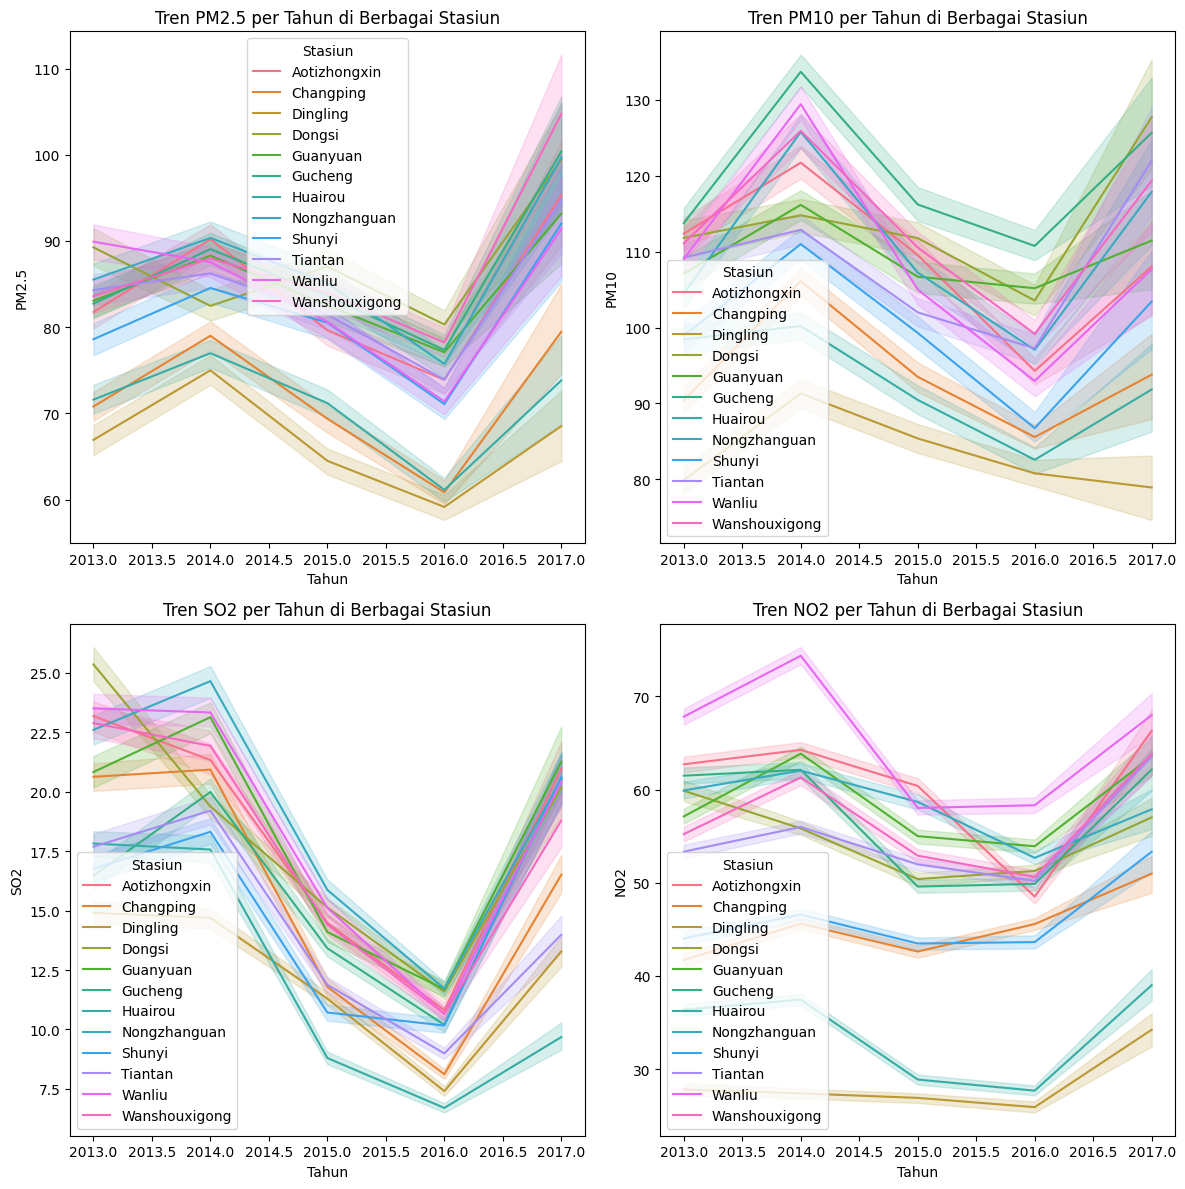

In [26]:
plt.figure(figsize=(12, 12))

pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2']

for i, pollutant in enumerate(pollutants):
    plt.subplot(2, 2, i + 1)
    sns.lineplot(data=air_quality_data, x='year', y=pollutant, hue='station')
    plt.title(f'Tren {pollutant} per Tahun di Berbagai Stasiun')
    plt.xlabel('Tahun')
    plt.ylabel(pollutant)
    plt.legend(title='Stasiun')

plt.tight_layout()
plt.show()

Visualisasi 2: Scatter plot TEMP vs PM2.5, PM10, SO2, NO2

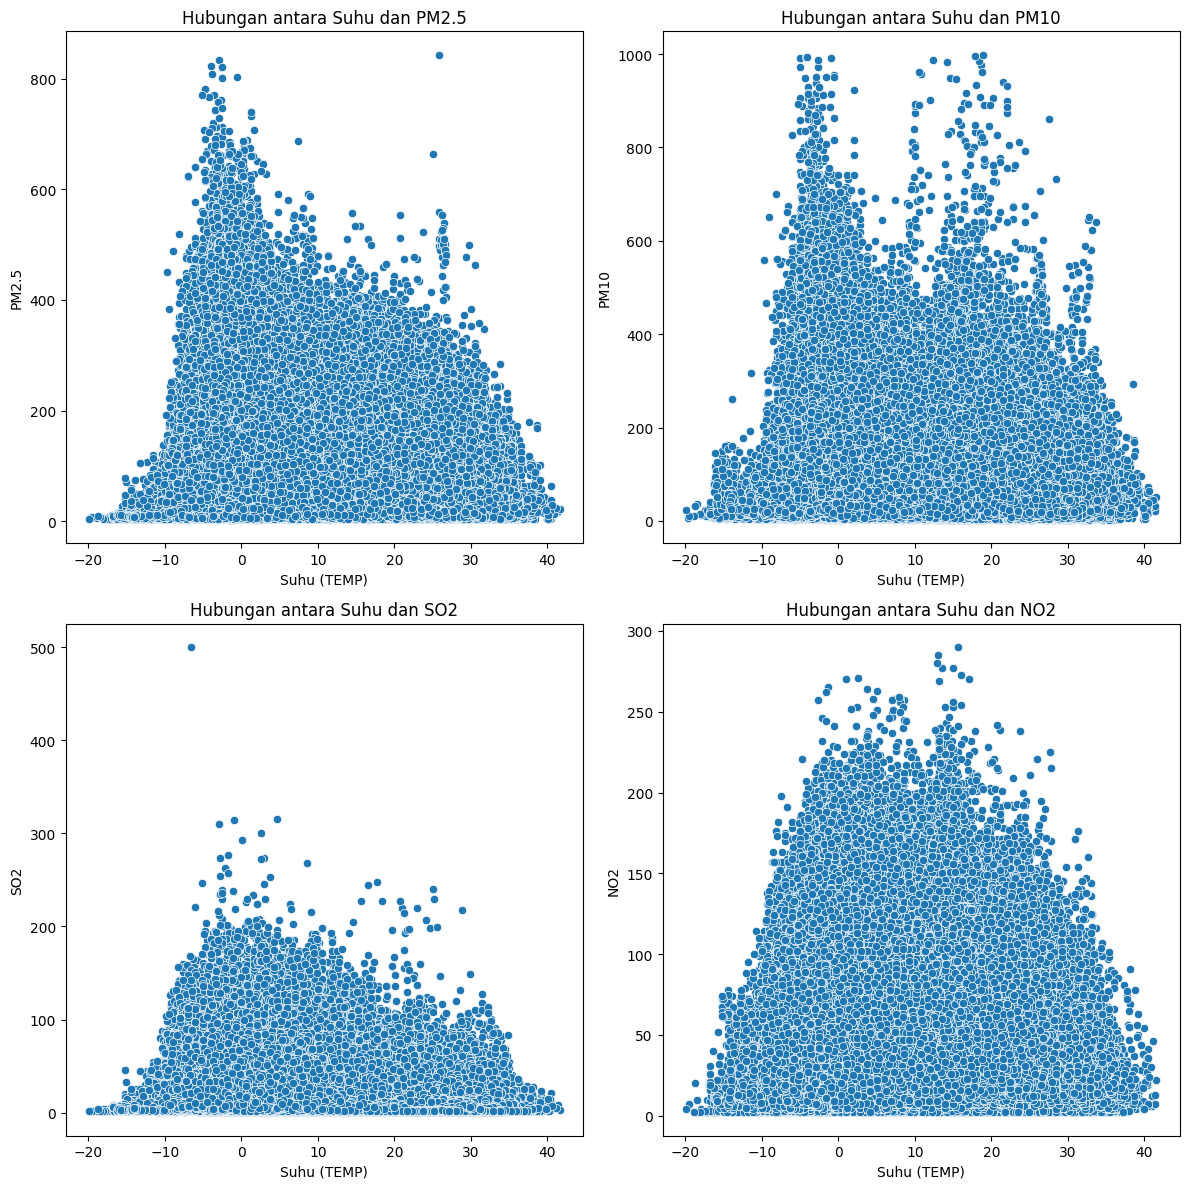

In [25]:
plt.figure(figsize=(12, 12))

for i, pollutant in enumerate(pollutants):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(data=air_quality_data, x='TEMP', y=pollutant)
    plt.title(f'Hubungan antara Suhu dan {pollutant}')
    plt.xlabel('Suhu (TEMP)')
    plt.ylabel(pollutant)

plt.tight_layout()
plt.show()

Visualisasi 3: Boxplot perbandingan PM2.5, PM10, SO2, NO2 antar stasiun

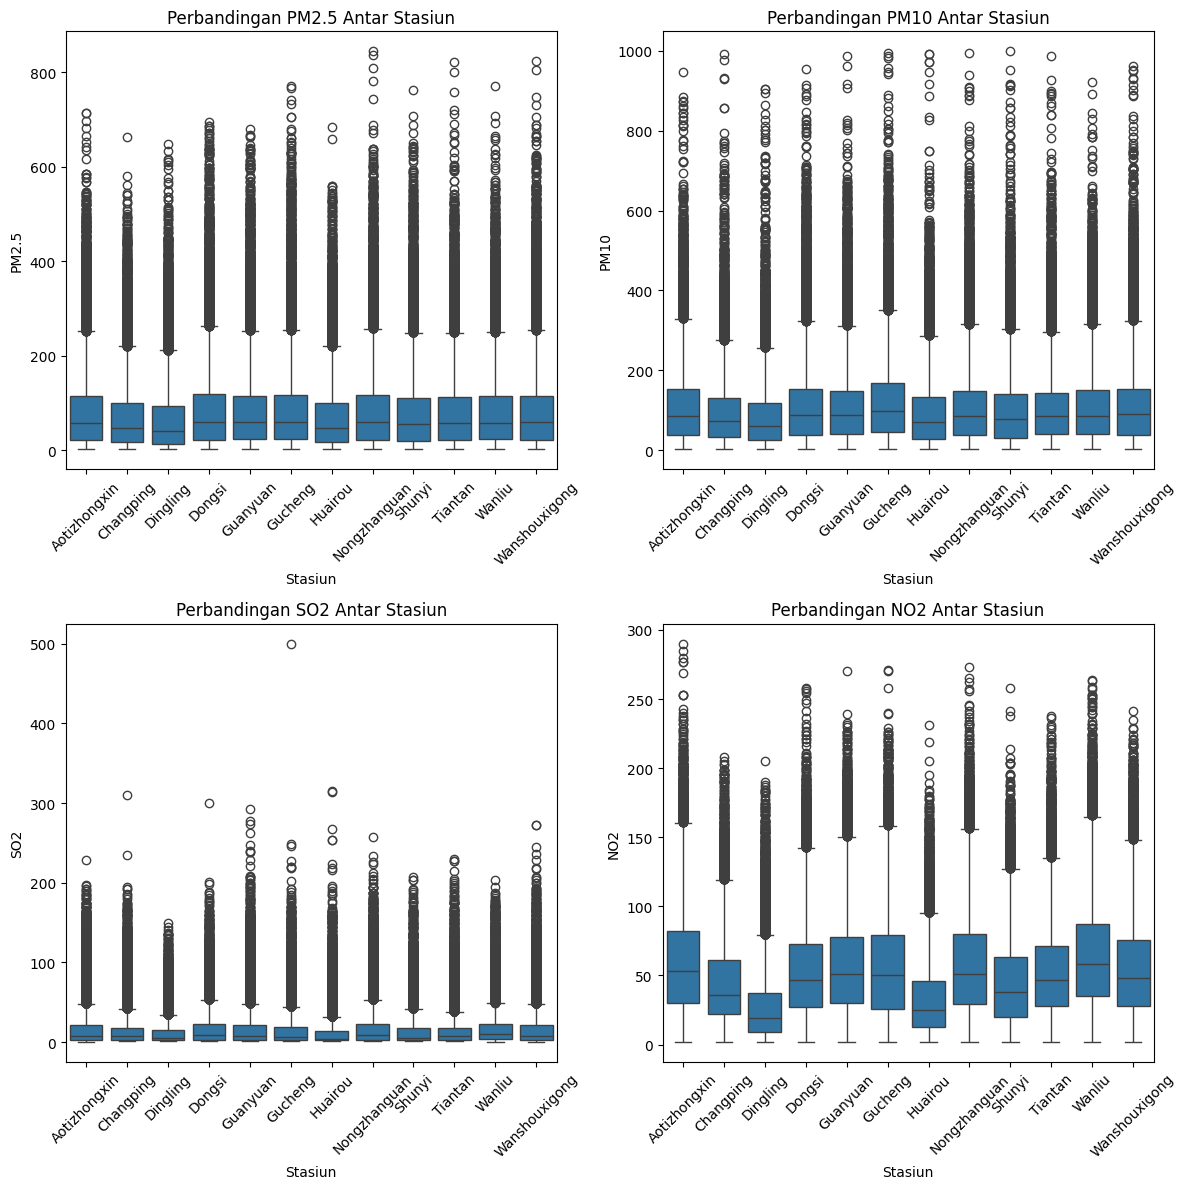

In [27]:
plt.figure(figsize=(12, 12))

for i, pollutant in enumerate(pollutants):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=air_quality_data, x='station', y=pollutant)
    plt.title(f'Perbandingan {pollutant} Antar Stasiun')
    plt.xticks(rotation=45)
    plt.xlabel('Stasiun')
    plt.ylabel(pollutant)

plt.tight_layout()
plt.show()

Visualisasi 4: Histogram distribusi PM2.5, PM10, SO2, NO2

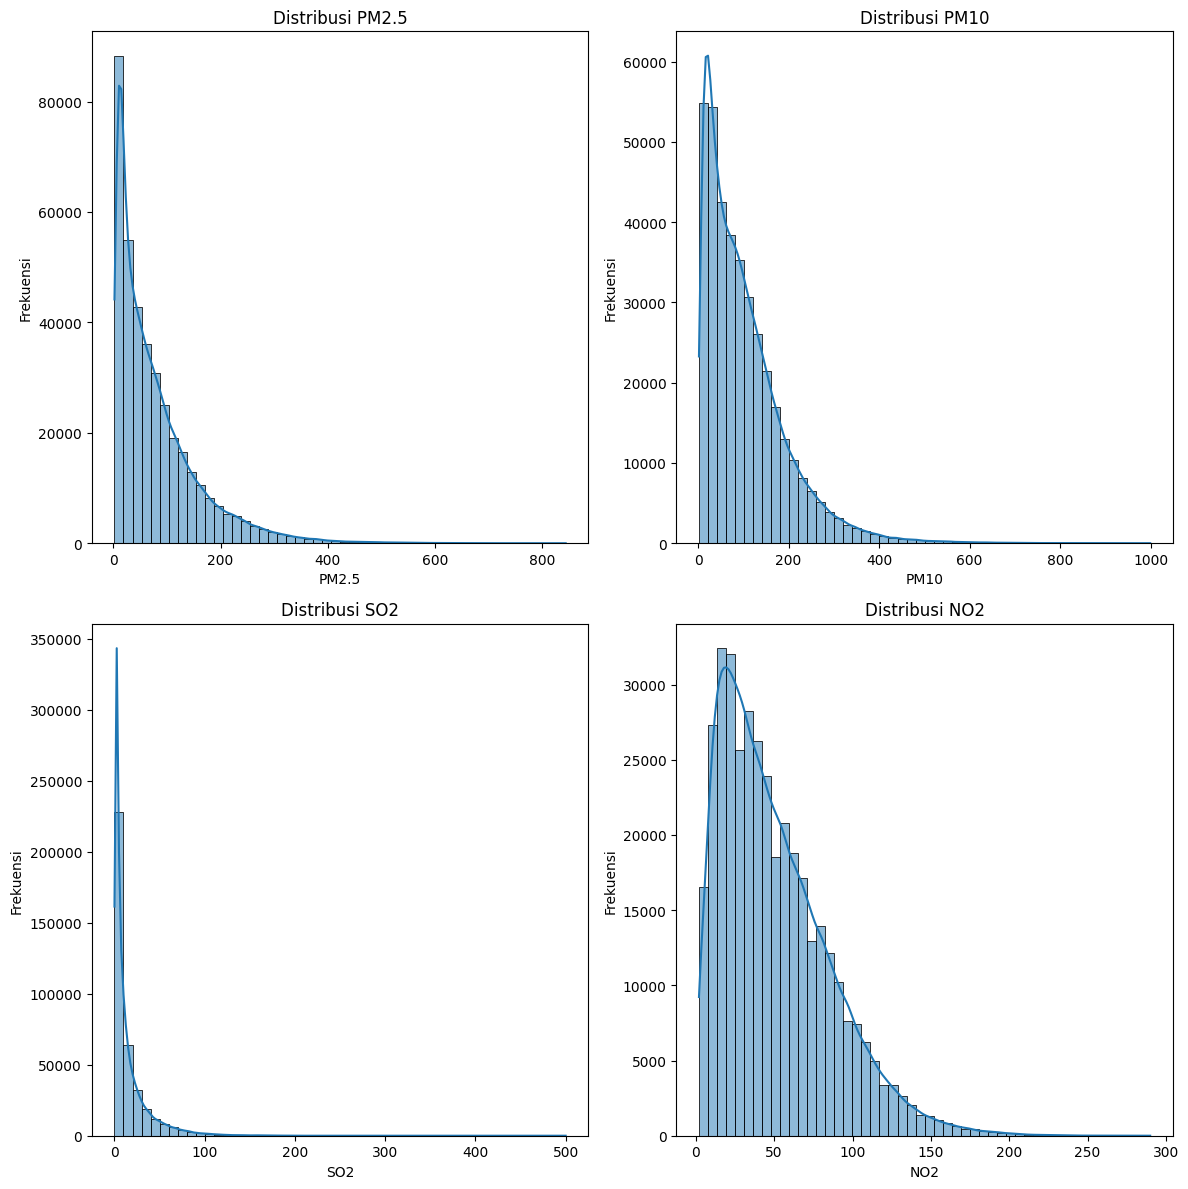

In [28]:
plt.figure(figsize=(12, 12))

for i, pollutant in enumerate(pollutants):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data=air_quality_data, x=pollutant, bins=50, kde=True)
    plt.title(f'Distribusi {pollutant}')
    plt.xlabel(pollutant)
    plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()

Visualisasi 5: Heatmap perbandingan polutan antar stasiun

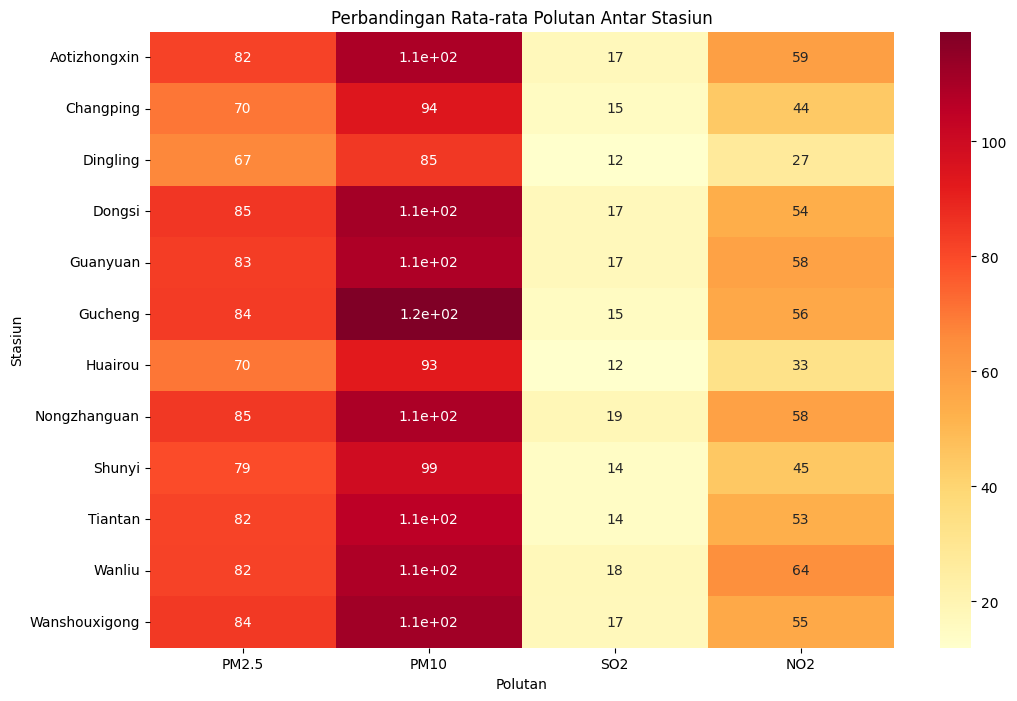

In [29]:
pollutant_means = air_quality_data.groupby('station')[pollutants].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(pollutant_means, annot=True, cmap='YlOrRd')
plt.title('Perbandingan Rata-rata Polutan Antar Stasiun')
plt.xlabel('Polutan')
plt.ylabel('Stasiun')
plt.show()

Visualisasi 6: Bar plot perbandingan rata-rata polutan antar stasiun

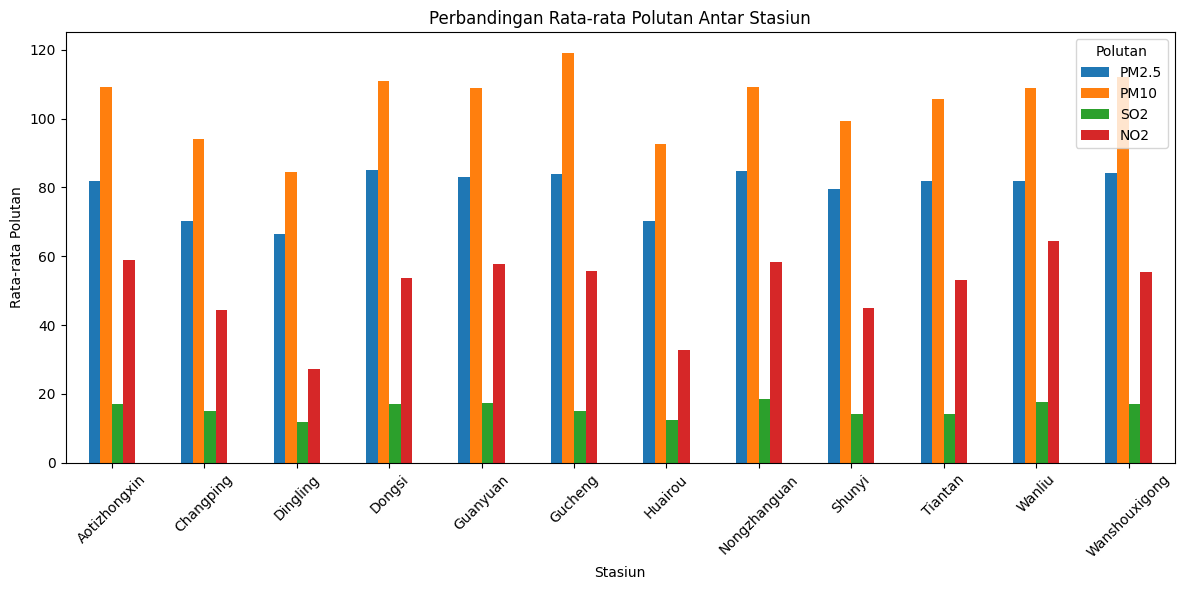

In [30]:
pollutant_means.plot(kind='bar', figsize=(12, 6))
plt.title('Perbandingan Rata-rata Polutan Antar Stasiun')
plt.xlabel('Stasiun')
plt.ylabel('Rata-rata Polutan')
plt.xticks(rotation=45)
plt.legend(title='Polutan')
plt.tight_layout()
plt.show()

Analisis korelasi

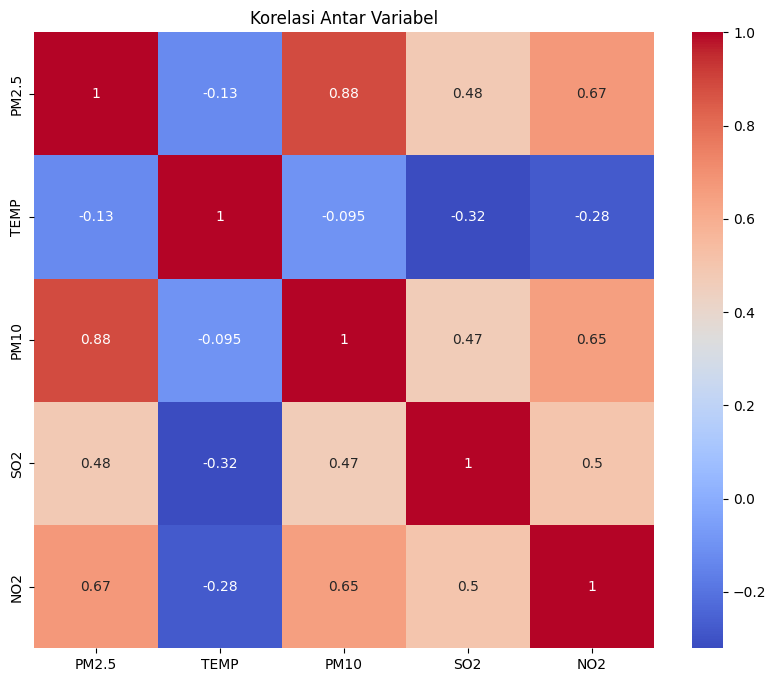

In [31]:

correlation = air_quality_data[['PM2.5', 'TEMP', 'PM10', 'SO2', 'NO2']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm') #, square=True)
plt.title('Korelasi Antar Variabel')
plt.show()

# Clustering Manual
ambang batas yang kita gunakan adalah:

PM2.5: Rendah < 35, Sedang 35-75, Tinggi > 75

PM10: Rendah < 50, Sedang 50-100, Tinggi > 100

SO2: Rendah < 20, Sedang 20-60, Tinggi > 60

NO2: Rendah < 40, Sedang 40-80, Tinggi > 80

Definisikan fungsi untuk mengkategorikan stasiun berdasarkan polutan

In [39]:
def categorize_pollutant(value, low, high):
    if value < low:
        return 'Rendah'
    elif low <= value <= high:
        return 'Sedang'
    else:
        return 'Tinggi'

Hitung rata-rata polutan per stasiun

In [40]:
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2']
pollutant_data = air_quality_data.groupby('station')[pollutants].mean()

Kategorikan setiap stasiun berdasarkan polutan

In [41]:
pollutant_data['PM2.5_Level'] = pollutant_data['PM2.5'].apply(categorize_pollutant, args=(35, 75))
pollutant_data['PM10_Level'] = pollutant_data['PM10'].apply(categorize_pollutant, args=(50, 100))
pollutant_data['SO2_Level'] = pollutant_data['SO2'].apply(categorize_pollutant, args=(20, 60))
pollutant_data['NO2_Level'] = pollutant_data['NO2'].apply(categorize_pollutant, args=(40, 80))


Tampilkan hasil clustering manual

In [42]:

print(pollutant_data[['PM2.5_Level', 'PM10_Level', 'SO2_Level', 'NO2_Level']])

              PM2.5_Level PM10_Level SO2_Level NO2_Level
station                                                 
Aotizhongxin       Tinggi     Tinggi    Rendah    Sedang
Changping          Sedang     Sedang    Rendah    Sedang
Dingling           Sedang     Sedang    Rendah    Rendah
Dongsi             Tinggi     Tinggi    Rendah    Sedang
Guanyuan           Tinggi     Tinggi    Rendah    Sedang
Gucheng            Tinggi     Tinggi    Rendah    Sedang
Huairou            Sedang     Sedang    Rendah    Rendah
Nongzhanguan       Tinggi     Tinggi    Rendah    Sedang
Shunyi             Tinggi     Sedang    Rendah    Sedang
Tiantan            Tinggi     Tinggi    Rendah    Sedang
Wanliu             Tinggi     Tinggi    Rendah    Sedang
Wanshouxigong      Tinggi     Tinggi    Rendah    Sedang


Visualisasi Clustering dengan Heatmap


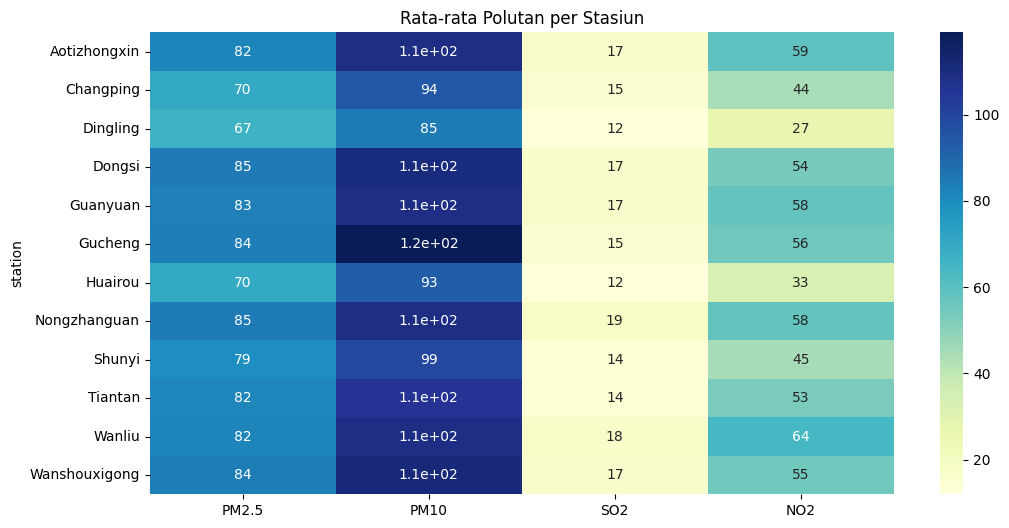

In [44]:
plt.figure(figsize=(12, 6))
sns.heatmap(pollutant_data[['PM2.5', 'PM10', 'SO2', 'NO2']], annot=True, cmap='YlGnBu')
plt.title('Rata-rata Polutan per Stasiun')
plt.show()

Uji hipotesis

In [33]:

t_stat, p_val = ttest_ind(air_quality_data['PM2.5'], air_quality_data['PM10'])
print(f'T-statistik: {t_stat}, p-value: {p_val}')


T-statistik: -127.86557753054527, p-value: 0.0


# Kesimpulan
1. Tren polutan menunjukkan variasi antar stasiun dan fluktuasi tahunan.
2. Ada korelasi lemah antara suhu dan PM2.5, menunjukkan faktor lain yang lebih berpengaruh.
3. Perbandingan tingkat polusi menunjukkan variasi antar stasiun dalam kota beijing.